In [112]:
import numpy as np
from scipy import stats 
import math
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from scipy.linalg import orth
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
# Device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
dtype = torch.cuda.FloatTensor

Generate_data

In [113]:

def generate_data(mu_,n,d,big_sigma_squared,sigma_z,N):
    c=np.random.normal(loc=0, scale=1.0, size=[d,N])
    z=np.random.normal(loc=0, scale=sigma_z, size=[n,N])
    U=orth(np.random.normal(loc=0, scale=1, size=[n,d]))
    L=np.random.choice([-1,1],N)
    L=L.reshape(L.shape[0],1)     
    if mu_==None:
        mu=np.random.choice([1,1],n)
        mu=mu.reshape(mu.shape[0],1)
    else:
        mu=np.random.choice([-mu_,mu_],n)
        mu=mu.reshape(mu.shape[0],1)
                
    U=U@big_sigma_squared
    X=U@c+mu@L.T 
    Y=X+z

    U = torch.from_numpy(U).type(dtype)
    X = torch.from_numpy(X).type(dtype)
    Y = torch.from_numpy(Y).type(dtype)
    L = torch.from_numpy(L).type(dtype)
    mu = torch.from_numpy(mu).type(dtype)
    
    return X,Y,U,L,mu

Compute the risk for a given estimator W subspace u ,distance mu and noise statistics sigma_z.

In [114]:
def test_risk_1(n,d,W,U,sigma_z,mu):    
    risk = torch.linalg.norm( (W - torch.eye(n).type(dtype)) @ U ,'fro')**2 + sigma_z**2 * torch.linalg.norm(W,'fro')**2 + 0.5*torch.linalg.norm( (W - torch.eye(n).type(dtype)) @ mu ,'fro')**2 + 0.5*torch.linalg.norm( (W - torch.eye(n).type(dtype)) @ (-1*mu) ,'fro')**2
    return risk/d

In [115]:
n=100
d=10
mu_=0.01
alpha1=1e-3
big_sigma_squared=np.eye(d)
sigma_z=0.05
train_size = [2,4,8,10,12,14,16,18,22,24,30,36,44,64,100,256,512,1024,2048,4096,8192,16384]
runs=2
precision = 8
X,Y,U,L,mu=generate_data(mu_,n,d,big_sigma_squared,sigma_z,N)
L=L.T
Xpi=torch.pinverse(X)
Ypi=torch.pinverse(Y)
Lpi=torch.pinverse(L)
W1=X@Ypi
a1=test_risk_1(n,d,W1,U,sigma_z,mu)

W2=X@Y.T@Ypi.T@X.T@Xpi.T@Y.T@Ypi.T@Lpi@L@Ypi
a2=test_risk_1(n,d,W2,U,sigma_z,mu)

In [116]:
print(a1)
print(a2)

tensor(0.0027, device='cuda:0')
tensor(1.0077, device='cuda:0')


In [117]:
learn_results = {'test_l':np.zeros([runs,len(train_size)]),'test_l2':np.zeros([runs,len(train_size)])}
for r in range(runs):
    print("**********run {}**********".format(r))
    for i,N in enumerate(train_size):
        print("*****training size (N) = {}*****".format(N))
        X,Y,U,L,mu = generate_data(mu_,n,d,big_sigma_squared,sigma_z,N)

        L=L.T
        Xpi=torch.pinverse(X)
        Ypi=torch.pinverse(Y)
        Lpi=torch.pinverse(L)

        W1=X@Ypi
        a1=test_risk_1(n,d,W1,U,sigma_z,mu@L)

        W2=X@Y.T@Ypi.T@X.T@Xpi.T@Y.T@Ypi.T@Lpi@L@Ypi
        a2=test_risk_1(n,d,W2,U,sigma_z,mu@L)
        
        learn_results['test_l'][r,i] = a1
        learn_results['test_l2'][r,i] = a2

results1m=learn_results['test_l'].mean(0)
results1s=learn_results['test_l'].std(0)
results2m=learn_results['test_l2'].mean(0)
results2s=learn_results['test_l2'].std(0)

**********run 0**********
*****training size (N) = 2*****
*****training size (N) = 4*****
*****training size (N) = 8*****
*****training size (N) = 10*****
*****training size (N) = 12*****
*****training size (N) = 14*****
*****training size (N) = 16*****
*****training size (N) = 18*****
*****training size (N) = 22*****
*****training size (N) = 24*****
*****training size (N) = 30*****
*****training size (N) = 36*****
*****training size (N) = 44*****
*****training size (N) = 64*****
*****training size (N) = 100*****
*****training size (N) = 256*****
*****training size (N) = 512*****
*****training size (N) = 1024*****
*****training size (N) = 2048*****
*****training size (N) = 4096*****
*****training size (N) = 8192*****
*****training size (N) = 16384*****
**********run 1**********
*****training size (N) = 2*****
*****training size (N) = 4*****
*****training size (N) = 8*****
*****training size (N) = 10*****
*****training size (N) = 12*****
*****training size (N) = 14*****
*****training si

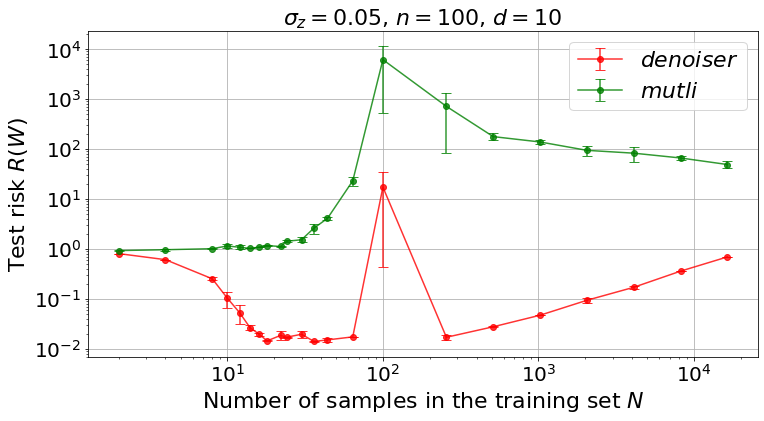

In [118]:
fontsize = 22

fig = plt.figure(figsize=(12,6))
al=0.8
ax = fig.add_subplot(111)

ax.errorbar(train_size, results1m, yerr=results1s, color='r', fmt="-o",alpha=al,label=r"$denoiser$", capsize=5)
ax.errorbar(train_size, results2m, yerr=results2s, color='g', fmt="-o",alpha=al,label=r"$mutli$", capsize=5)

ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.set_title('$\sigma_z=${}, $n=${}, $d=${}'.format(sigma_z,n,d), fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([0,20])

plt.grid()
plt.show()